# GA 2.6: A stethoscope for beams - neural networks for detecting defects on bridges

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0"\>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0"\>
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.6. Due: Friday, Dec 20, 2024.*

<div style="background-color:#FFC5CB; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>

This notebook includes boxes with the formatting shown here to list the questions you are expected to answer in your report. You are not expected to write your answers here.

## Introduction

In this notebook, you should apply the techniques you learned for regression in a more realistic problem setting. We have a collection of 1000 bridges modeled as 2D beams that all feature a defect (crack) that can be located anywhere along the span of the beam: 
<center>
    <img src="./figs/beam.svg" width="500"/>
    <figcaption><b>Figure 1.</b> A bridge idealized as a 2D beam. Somewhere along the span there is a crack we are trying to detect.</figcaption>
</center>

Let us assume that we built these 1000 beams, purposefully inserted a defect in each of them at random locations, and then loaded them to measure how they deform. Our goal is to, given a new bridge for which we do not know where the defect is located, detect where it is without having to demolish the bridge. It is reasonable to assume that the presence of the crack will affect how the bridge deforms under loading, so we can try to use displacement sensors to estimate where the crack is. Since installing and monitoring displacement sensors is an expensive endeavor, we try to use as few sensors as we can. 

We will use neural networks to map sensor displacements to crack locations:

<div>
<center><img src="./figs/net.svg" width="600"/>
<figcaption><b>Figure 3.</b> Artificial neural network representation, with a zoomed-in view of how a single neuron works.</figcaption></center>
</div>

and train it with the 1000 bridges in our dataset. When it is time to make predictions for a new structure, we can just feed the measured displacements as inputs and get the estimated crack location as output.

The assignment includes the following tasks:

- Pre-process the available data to use it in a neural network
- Train a neural network to learn a mapping from the displacement measurements to the defect location, comment on the choice of hyperparameters (number of hidden layers, nodes per layer, ...)
- Visualise your results and evaluate the accuracy of your network

and is split in two parts: **first we use only one sensor** at the center of the beam and then look at our results; **then we add two more sensors** midway between halfspan and the supports and see how that improves predictions.



## Preliminaries

### Libraries

To run this notebook you need to have installed the following packages:
- Numpy
- Matplotlib
- Pandas
- Scikit-learn

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Load the dataset 

Let us take a look at the dataset first. It is a CSV file, and a convenient way to read and manipulate this file type is via the `Dataframe` of the `pandas` library.

In [2]:
data = pd.read_csv(r"data/bridges.csv")

In [3]:
#summary of the data
data.describe()

,sample,location,node,x,y,dx,dy
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.0,3000.000000,3000.000000
mean,499.500000,4.836256,28.666667,4.933333,0.0,0.014143,-0.038273
std,288.723115,2.894467,10.210630,2.042126,0.0,0.007008,0.005674
min,0.000000,0.044241,16.000000,2.400000,0.0,0.005423,-0.046335
25%,249.750000,2.220470,16.000000,2.400000,0.0,0.005486,-0.046155
50%,499.500000,4.851140,29.000000,5.000000,0.0,0.014336,-0.035304
75%,749.250000,7.282190,41.000000,7.400000,0.0,0.022605,-0.033339
max,999.000000,9.963194,41.000000,7.400000,0.0,0.022705,-0.033214


We can take a look at how the crack location relates with displacements at three different locations along the beams (25% of the span, midspan, 75% of the span):

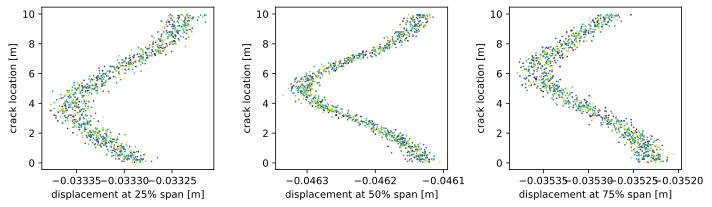

In [4]:
from matplotlib import cm

loc1 = data[data['node'] == 16] # point at 25% span
loc2 = data[data['node'] == 29] # point at midspan
loc3 = data[data['node'] == 41] # point at 75% span

fig,axes = plt.subplots(1,3,figsize=(10,3))

axes[0].scatter(loc1['dy'], loc1['location'], c=loc1['sample'], s=0.5)
axes[0].set_xlabel('displacement at 25% span [m]')
axes[0].set_ylabel('crack location [m]')

axes[1].scatter(loc2['dy'], loc1['location'], c=loc2['sample'], s=0.5)
axes[1].set_xlabel('displacement at 50% span [m]')
axes[1].set_ylabel('crack location [m]')

axes[2].scatter(loc3['dy'], loc1['location'], c=loc3['sample'], s=0.5)
axes[2].set_xlabel('displacement at 75% span [m]')
axes[2].set_ylabel('crack location [m]')

plt.tight_layout()
plt.show()

Perhaps you can already see this will be a challenging endeavor, especially using just one of these input features. In the figure above we identify each beam with a unique color, so you can see that to really get it right we might need to gather information from multiple sensors. Look for instance at the middle plot: for a displacement of around $-0.0461$ our defect might either be at $x=0$ or $x=10$, so at the two opposite ends of the beam! Can you reason out why that is the case?

For now let us start with a model with a single feature (displacement at midspan, a.k.a. `loc2`) and see how well we do.

## 1. Data Pre-Processing

### Splitting the data into training, validation, and testing sets

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 1.1:</b>   

In machine learning, it is common to split the dataset into three parts: a training set, a validation set, and a test set. 

Your task is to write a Python code snippet that splits a given dataset into these three parts. The dataset consists of `features` and `targets`.

The dataset should be split as follows:

- 80% of the data should go to the training set.
- 10% of the data should go to the validation set.
- 10% of the data should go to the test set.

The splitting should be done in a way that shuffles the data first to ensure that the training, validation, and test sets are representative of the overall distribution of the data. You can set the random state for the shuffling to ensure that the results are reproducible; you can use the values 42 for the first split and 24 for the second split.

The resulting training, validation, and test sets should be stored in the variables `X_train`, `t_train`, `X_val`, `t_val`, `X_test`, and `t_test`.

**Hint:** You can use the `train_test_split` function from the `sklearn.model_selection` module to perform the splitting.
</div>

<div>
<center><img src="./figs/splitting.svg" width="400"/>
<figcaption><b>Figure 3.</b> Splitting the dataset into training, validation and test sets.</figcaption></center>
</div>

In [5]:
features = loc2['dy'].to_numpy().reshape(-1,1)
targets = loc2['location'].to_numpy().reshape(-1,1)

X_train, X_val_test, t_train, t_val_test = train_test_split(features, targets, test_size=0.20, random_state=42)
X_val, X_test, t_val, t_test = train_test_split(X_val_test, t_val_test, test_size=0.50, random_state=24)

### Normalizing the data

Now, we normalize the data using the MinMaxScaler from scikit-learn. This scaler transforms the data to be between 0 and 1. This is important because the neural net will be trained using gradient descent, which is sensitive to the scale of the data. Notice that we use the training data to fit the scaler. This is important because we assume that the model only sees the training data and we do not use any of the validation or testing data.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 1.2:</b>   

In machine learning, it is often beneficial to normalize the feature variables to a specific range. This can help the model converge faster during training and can also prevent certain features from dominating others due to their scale.

Your task is to write a Python code snippet that normalizes the feature variables of a training set and a validation set to the range [0, 1]. The feature variables are stored in the variables `X_train` and `X_val`.

You should use the `MinMaxScaler` class from the `sklearn.preprocessing` module to perform the normalization. This class scales and translates each feature individually such that it is in the given range on the training set. Remember we should fit the normalizer with **only the training dataset**!

The normalized features should be stored in the variables `normalized_X_train` and `normalized_X_val`.

**Hint**: See how we did this in the workshop assignment!

In [6]:
scaler_x = MinMaxScaler()

scaler_x.fit(X_train)

normalized_X_train = scaler_x.transform(X_train)
normalized_X_val = scaler_x.transform(X_val)

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 1.3:</b>   

We now do the same for the targets. Your task is to write a Python code snippet that normalizes the target variables of a training set and a validation set to the range [0, 1]. The target variables are stored in the variables `t_train` and `t_val`.

The normalized targets should be stored in the variables `normalized_t_train` and `normalized_t_val`. 

**Hint**: See how we did this in the workshop assignment!
</div>

In [7]:
scaler_t = MinMaxScaler()

scaler_t.fit(t_train)

normalized_t_train = scaler_t.transform(t_train)
normalized_t_val = scaler_t.transform(t_val)

<div style="background-color:#FFC5CB; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>

1.1) What is the purpose of splitting a dataset into training, validation, and test sets in the context of machine learning?

1.2) Why should the `MinMaxScaler` be fitted on the training data only?

1.3) Why is it crucial that the exact same scaler is used to transform the validation dataset?

## 2. Defining and training an MLP

Now, we will define and train a Multilayer Perceptron (MLP), which is the name we give to a simple (feedforward) neural network. In Scikit-learn, the MLP is defined in the MLPRegressor class, **you can see the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)**. This class has many hyperparameters that can be tuned to improve the performance of the model. Notice that in Scikit-learn, the model and the optimizer are defined in the same class. This means that we do not need to define an optimizer separately; therefore, some hyperparameters are related to the optimizer. For example, the learning rate. We will indicate the optimization hyperparameters in the next section; for now, we will only define the model hyperparameters.

### Training the model

Once we have a model in place we will need to train it. Scikit-learn offers the possibility to directly train a model using the `fit` method. However, we will define a training loop to have more control over the training process. This will allow us to evaluate the model at each epoch and observe its training.

The first step towards training a model is defining a function that transforms our training dataset into random mini-batches. This is a common practice used for training neural networks due to their computational efficiency and their ability to help the model generalize better. This practice generally leads to better computational efficiency, faster convergence and better generalization performance.

In [8]:
def get_mini_batches(X, t, batch_size):
    """
    This function generates mini-batches from the given input data and labels.

    Parameters:
    X (numpy.ndarray): The features.
    t (numpy.ndarray): The targets corresponding to the input data.
    batchsize (int): The size of each mini-batch.

    Returns:
    list: A list of tuples where each tuple contains a mini-batch of the input data and the corresponding targets.
    """
    # Generate permutations
    perm = np.random.permutation(len(X))
    X_train_perm = X[perm]
    t_train_perm = t[perm]
    
    # Generate mini-batches
    X_batches = []
    t_batches = []
    for i in range(0, len(X_train_perm), batch_size):
        X_batches.append(X_train_perm[i:i+batch_size])
        t_batches.append(t_train_perm[i:i+batch_size])

    return list(zip(X_batches, t_batches))

The following figure illustrates both the way we split the original dataset and how we further split the training dataset into mini-batches. At every epoch the training dataset is shuffled and each mini-batch is considered **in isolation** by the network. The gradients coming from the single mini-batches are used to update the weights of the network (the randomness involved is why we say we are using **Stochastic** Gradient Descent).

<div>
<center><img src="./figs/minibatching.svg" width="600"/>
<figcaption><b>Figure 4.</b> Dataset splitting, mini-batching and the stochastic nature of MLP training.</figcaption></center>
</div>

Now, we will define some hyperparameters for the training loop. These hyperparameters are related to the optimization process.
Define the following hyperparameters:
- `learning_rate` (float): The learning rate of the optimizer.
- `n_epochs` (int): The number of epochs to train the model. (For time reasons, we will only train the model for 20 epochs. However, you can increase this number to improve the performance of the model.)
- `batch_size` (int): The size of each mini-batch.

In [9]:
learning_rate = 0.001
n_epochs = 20
batch_size = 64

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.1:</b> 

In this exercise, you are tasked with implementing a function to train a neural network model. The function should also compute and store the loss on the training and validation sets at each epoch. The loss function to be used is the Mean Squared Error (MSE), which is defined as:

$$ MSE = \frac{1}{N} \sum_{n=1}^{N} (t_n - y_n)^2 $$

where $t_n$ is the actual target, $y_n$ is the predicted value, and $N$ is the number of samples.

The function should be named `train_model` and should take the following parameters:

- `model`: An instance of a neural network model that we want to train.
- `normalized_X_train`: The normalized training data.
- `normalized_t_train`: The normalized training labels.
- `normalized_X_val`: The normalized validation data.
- `normalized_t_val`: The normalized validation labels.
- `n_epochs`: The number of epochs to train the model for.
- `batch_size`: The size of each mini-batch.
- `learning_rate`: The learning rate for the model.

The function should perform the following steps:

1. Initialize two empty lists, `train_loss_list` and `val_loss_list`, to store the training and validation losses at each epoch.

2. Loop over the specified number of epochs. For each epoch:

    a. Generate mini-batches from the normalized training data and labels using a function `get_mini_batches(normalized_X_train, normalized_t_train, batch_size)`;

    b. For each mini-batch, update the model weights using the `partial_fit` method of the model. Do not forget to `flatten()` the targets;

    c. Compute the MSE loss on the training set and append it to `train_loss_list`;

    d. Compute the MSE loss on the validation set and append it to `val_loss_list`;

    e. Print the training progress including the current epoch and the training and validation losses;

    f. Return the `train_loss_list` and `val_loss_list` lists.

Your task is to write the Python code that implements the `train_model` function.
</div>

In [10]:
def train_model(model, normalized_X_train, normalized_t_train, normalized_X_val, normalized_t_val, n_epochs, batch_size, learning_rate, verbose=True):
    train_loss_list = []
    val_loss_list = []
    model.learning_rate_init = learning_rate

    # Fix random seed for reproducibility
    np.random.seed(42)
    
    for epoch in range(n_epochs):
        
        # Generate mini-batches
        mini_batches = get_mini_batches(normalized_X_train, normalized_t_train, batch_size)
        
        # Train model on mini-batches
        for X_batch, t_batch in mini_batches:
            model.partial_fit(X_batch, t_batch.flatten())
        
        # Compute loss on training and validation sets
        train_loss = mean_squared_error(normalized_t_train, model.predict(normalized_X_train))
        
        # Compute loss on validation set
        val_loss = mean_squared_error(normalized_t_val, model.predict(normalized_X_val))

        # Store loss values
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        # Print training progress
        if verbose:
            print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss_list[-1]:.4f} - Val Loss: {val_loss:.4f}")
        
    return train_loss_list, val_loss_list


<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.2:</b>   
You are tasked with setting up a Multi-Layer Perceptron (MLP). The MLP should have the following characteristics:

 - The hidden layer sizes are defined as a tuple. For this task we want to have two hidden layers with 10 and 5 neurons, respectively, so we should write: hidden_layer_sizes=(10,5). Notice that we only specify the hidden layer sizes, the input and output sizes will be automatically inferred when we train the model. 
 - The activation function can be one of the following: 'identity', 'logistic', 'tanh', 'relu'. But for this task you should set it to 'tanh'.

The configured `MLPRegressor` should be stored in a variable named `model`. We then call the training function we defined above and pass this model as argument.

Training neural networks is a stochastic operation: the MLP is given **random initial weights** and SGD is random by nature. If you want to make sure you always get the same trained network every time you run the notebook (e.g. for comparison reasons), you can pass `random_state=0` (or some other integer) to `MLPRegressor`
</div>

In [11]:
model = MLPRegressor(hidden_layer_sizes = (10, 5), 
                    activation = 'tanh',
                    random_state=1)

train_loss_list, val_loss_list = train_model(model, normalized_X_train, normalized_t_train, normalized_X_val, normalized_t_val, n_epochs, batch_size, learning_rate)

Epoch 1/20 - Train Loss: 0.2700 - Val Loss: 0.2962
Epoch 2/20 - Train Loss: 0.1554 - Val Loss: 0.1742
Epoch 3/20 - Train Loss: 0.1036 - Val Loss: 0.1164
Epoch 4/20 - Train Loss: 0.0890 - Val Loss: 0.0979
Epoch 5/20 - Train Loss: 0.0869 - Val Loss: 0.0940
Epoch 6/20 - Train Loss: 0.0868 - Val Loss: 0.0930
Epoch 7/20 - Train Loss: 0.0864 - Val Loss: 0.0928
Epoch 8/20 - Train Loss: 0.0861 - Val Loss: 0.0925
Epoch 9/20 - Train Loss: 0.0859 - Val Loss: 0.0923
Epoch 10/20 - Train Loss: 0.0857 - Val Loss: 0.0922
Epoch 11/20 - Train Loss: 0.0856 - Val Loss: 0.0920
Epoch 12/20 - Train Loss: 0.0854 - Val Loss: 0.0916
Epoch 13/20 - Train Loss: 0.0853 - Val Loss: 0.0914
Epoch 14/20 - Train Loss: 0.0852 - Val Loss: 0.0912
Epoch 15/20 - Train Loss: 0.0851 - Val Loss: 0.0910
Epoch 16/20 - Train Loss: 0.0850 - Val Loss: 0.0908
Epoch 17/20 - Train Loss: 0.0850 - Val Loss: 0.0909
Epoch 18/20 - Train Loss: 0.0849 - Val Loss: 0.0908
Epoch 19/20 - Train Loss: 0.0849 - Val Loss: 0.0905
Epoch 20/20 - Train L

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.3:</b>   
    Plot the validation and training loss curves. Add this plot to your report.
</div>

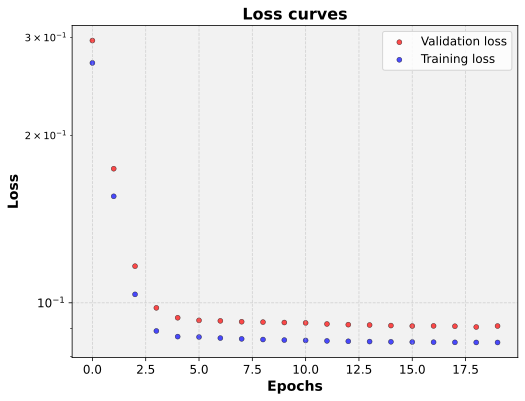

In [12]:
# Create a scatter plot with enhanced styling
plt.figure(figsize=(8, 6))  # Set the figure size

x_axis = list(range(len(train_loss_list)))

# Create a scatter plot
# plt.scatter(x_axis, YOUR_CODE_HERE, label='Validation loss', color='red', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)
# plt.scatter(x_axis, YOUR_CODE_HERE, label='Training loss', color='blue', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)
# Solution:
plt.scatter(x_axis, val_loss_list, label='Validation loss', color='red', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)
plt.scatter(x_axis, train_loss_list, label='Training loss', color='blue', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)

# Add labels and a legend with improved formatting
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Loss curves', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=12)

# Set the y-axis to be logarithmic
plt.yscale('log')

# Customize the grid appearance
plt.grid(True, linestyle='--', alpha=0.5)

# Customize the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a background color to the plot
plt.gca().set_facecolor('#f2f2f2')
plt.show()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.4:</b>

Now let us look at how well our model performs. With only one input feature, one easy way to do this is by just plotting $y(x)$ for the whole range of $x$. Since we have normalized our inputs with a `MinMaxScaler`, it is reasonable to form a simple `linspace` in $[0,1]$. We can then plot this function $y(x)$ together with our training and validation data to have an idea of how close model predictions are.

In the block below we already prepare a `normalized_X_range` for you to feed to the model (remember the network learned to use normalized inputs). Your task is to compute model predictions and store them in `t_range`. Remember to de-normalize what comes out of the network.

Add these plots to your report.
</div>

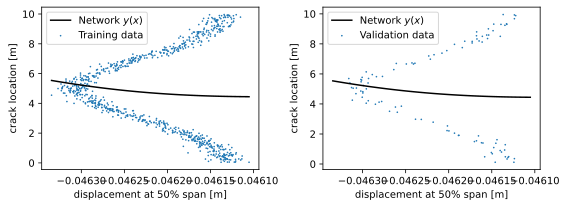

In [13]:
normalized_X_range = np.linspace(0,1,100).reshape(-1,1)
X_range = scaler_x.inverse_transform(normalized_X_range)

normalized_y_range = model.predict(normalized_X_range).reshape(-1,1)
y_range = scaler_t.inverse_transform(normalized_y_range)

fig,axes = plt.subplots(1,2,figsize=(8,3))

axes[0].plot(X_range, y_range, label=r"Network $y(x)$", color='k')
axes[0].scatter(X_train,t_train,s=0.5, label='Training data')
axes[0].set_xlabel('displacement at 50% span [m]')
axes[0].set_ylabel('crack location [m]')

axes[1].plot(X_range, y_range,label=r"Network $y(x)$", color='k')
axes[1].scatter(X_val,t_val,s=0.5, label='Validation data')
axes[1].set_xlabel('displacement at 50% span [m]')
axes[1].set_ylabel('crack location [m]')

axes[0].legend()
axes[1].legend()
plt.tight_layout()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.5:</b>

Another useful way to visualize our results is to use a so-called **parity plot**. This consists in plotting targets on the x-axis against network predictions on the y-axis, in other words a $t$ versus $y$ plot. For a model that always makes perfect predictions, $y=t$ for all instances of the target, which would make all points in the plot lie on the diagonal line $y=x$. In practice model predictions are often far from perfect, and this deviation would be seen as the points drifting away from the diagonal.

Your task is to set up two parity plots for this model, one for training data and one for validation data.

Add these plots to your report.
</div>

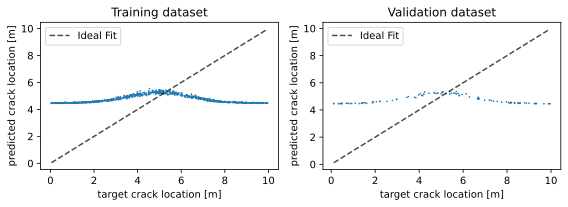

In [14]:
y_train = scaler_t.inverse_transform(model.predict(normalized_X_train).reshape(-1,1))
y_val = scaler_t.inverse_transform(model.predict(normalized_X_val).reshape(-1,1))

fig,axes = plt.subplots(1,2,figsize=(8,3))

axes[0].scatter(t_train,y_train,s=0.5)

axes[0].set_title('Training dataset')
axes[0].set_xlabel('target crack location [m]')
axes[0].set_ylabel('predicted crack location [m]')

min_val = min(np.min(t_train), np.min(y_train))
max_val = max(np.max(t_train), np.max(y_train))
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[0].legend()

# axes[1].scatter(YOUR_CODE_HERE,YOUR_CODE_HERE,s=0.5)
# Solution
axes[1].scatter(t_val,y_val,s=0.5)

axes[1].set_title('Validation dataset')
axes[1].set_xlabel('target crack location [m]')
axes[1].set_ylabel('predicted crack location [m]')

min_val = min(np.min(t_val), np.min(y_val))
max_val = max(np.max(t_val), np.max(y_val))
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[1].legend()

plt.tight_layout()

<div style="background-color:#FFC5CB; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>

2.1) Based on the shape of the loss curves, what can you indicate about the fitting capabilities of the model? (Is it overfitting, underfitting, or neither?)

2.2) Why is the model performing so poorly? Can you give an explanation based on the physics of the problem? Is there a crack location for which this model does make a good prediction? Why is that the case?

2.3) Can you explain why the model performs poorly in light of the assumptions we made for our observation model $p(t\vert x)=\mathcal{N}\left(t\lvert y(x),\beta^{-1}\right)$?

## 3. Using more input features

Let us now try the model with **three sensors** as input features and see if that improves our predictions. We follow the exact same procedure as before.

### Set up and train the new model

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 3.1:</b>

Use this block to set up a new neural network that now takes all three input features (displacements at three different sensors). The $[1000\times 3]$ feature matrix `features` and the $[1000\times 1]$ target vector `targets` are already done for you.

Now get all the code you need from the code blocks in Part 2 and paste them here. You need to (i) split your dataset again since it has changed; (ii) normalize features and targets; (iii) adjust the number of epochs and model architecture until you are satisfied with the model; (iv) set up an `MLPRegressor` and call `train_model`.

To reach a good architecture and number of epochs you will need to also complete Task 3.2 and rerun these two blocks until you are satisfied with the number you picked. Try out different activation functions to see what works best.
</div>

In [15]:
features = np.array([loc1['dy'].to_numpy(), loc2['dy'].to_numpy(), loc3['dy'].to_numpy()]).transpose()
targets = loc2['location'].to_numpy().reshape(-1,1)

X_train, X_val_test, t_train, t_val_test = train_test_split(features, targets, test_size=0.20, random_state=42)
X_val, X_test, t_val, t_test = train_test_split(X_val_test, t_val_test, test_size=0.50, random_state=24)

scaler_x = MinMaxScaler()
scaler_x.fit(X_train)

normalized_X_train = scaler_x.transform(X_train)
normalized_X_val = scaler_x.transform(X_val)

scaler_t = MinMaxScaler()
scaler_t.fit(t_train)

normalized_t_train = scaler_t.transform(t_train)
normalized_t_val = scaler_t.transform(t_val)

model = MLPRegressor(hidden_layer_sizes = (10, 5), 
                    activation = 'tanh')

learning_rate = 0.001
n_epochs = 200
batch_size = 64

train_loss_list, val_loss_list = train_model(model, normalized_X_train, normalized_t_train, normalized_X_val, normalized_t_val, n_epochs, batch_size, learning_rate)

Epoch 1/200 - Train Loss: 0.1834 - Val Loss: 0.2043
Epoch 2/200 - Train Loss: 0.0945 - Val Loss: 0.1073
Epoch 3/200 - Train Loss: 0.0606 - Val Loss: 0.0684
Epoch 4/200 - Train Loss: 0.0513 - Val Loss: 0.0566
Epoch 5/200 - Train Loss: 0.0489 - Val Loss: 0.0529
Epoch 6/200 - Train Loss: 0.0472 - Val Loss: 0.0508
Epoch 7/200 - Train Loss: 0.0452 - Val Loss: 0.0488
Epoch 8/200 - Train Loss: 0.0431 - Val Loss: 0.0468
Epoch 9/200 - Train Loss: 0.0411 - Val Loss: 0.0447
Epoch 10/200 - Train Loss: 0.0391 - Val Loss: 0.0425
Epoch 11/200 - Train Loss: 0.0371 - Val Loss: 0.0403
Epoch 12/200 - Train Loss: 0.0351 - Val Loss: 0.0381
Epoch 13/200 - Train Loss: 0.0331 - Val Loss: 0.0359
Epoch 14/200 - Train Loss: 0.0312 - Val Loss: 0.0338
Epoch 15/200 - Train Loss: 0.0293 - Val Loss: 0.0318
Epoch 16/200 - Train Loss: 0.0276 - Val Loss: 0.0299
Epoch 17/200 - Train Loss: 0.0260 - Val Loss: 0.0281
Epoch 18/200 - Train Loss: 0.0245 - Val Loss: 0.0264
Epoch 19/200 - Train Loss: 0.0231 - Val Loss: 0.0247
Ep

### Plot the evolution of training

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 3.2:</b>

Use this block to plot how the losses evolve with epochs. Once again you can reuse code from before. 

Add the plots to your report. Include only results from your final model (the one you are most satisfied with)
</div>

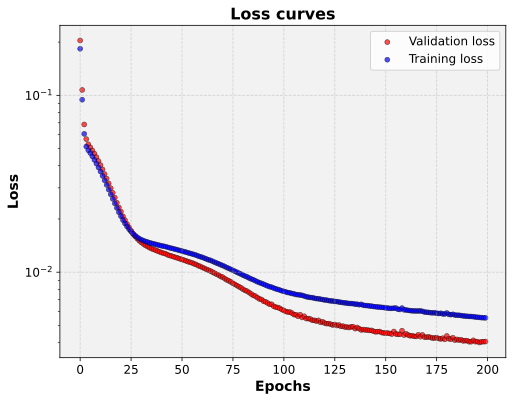

In [16]:
# Create a scatter plot with enhanced styling
plt.figure(figsize=(8, 6))  # Set the figure size

x_axis = list(range(len(train_loss_list)))

plt.scatter(x_axis, val_loss_list, label='Validation loss', color='red', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)
plt.scatter(x_axis, train_loss_list, label='Training loss', color='blue', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)

# Add labels and a legend with improved formatting
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Loss curves', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=12)

# Set the y-axis to be logarithmic
plt.yscale('log')

# Customize the grid appearance
plt.grid(True, linestyle='--', alpha=0.5)

# Customize the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a background color to the plot
plt.gca().set_facecolor('#f2f2f2')
plt.show()

### Evaluate the new model with parity plots

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 3.3:</b>
    
Use this block to make parity plots for your new model for both training and validation datasets. Once again you can reuse code from before. 

Add the plots to your report. Include only results from your final model (the one you are most satisfied with)
</div>

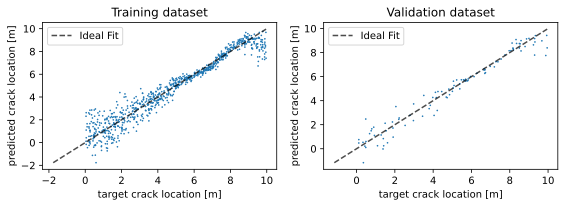

In [17]:
y_train = scaler_t.inverse_transform(model.predict(normalized_X_train).reshape(-1,1))
y_val = scaler_t.inverse_transform(model.predict(normalized_X_val).reshape(-1,1))

fig,axes = plt.subplots(1,2,figsize=(8,3))

axes[0].scatter(t_train,y_train,s=0.5)

axes[0].set_title('Training dataset')
axes[0].set_xlabel('target crack location [m]')
axes[0].set_ylabel('predicted crack location [m]')

min_val = min(np.min(t_train), np.min(y_train))
max_val = max(np.max(t_train), np.max(y_train))
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[0].legend()

# axes[1].scatter(YOUR_CODE_HERE,YOUR_CODE_HERE,s=0.5)
# Solution
axes[1].scatter(t_val,y_val,s=0.5)

axes[1].set_title('Validation dataset')
axes[1].set_xlabel('target crack location [m]')
axes[1].set_ylabel('predicted crack location [m]')

min_val = min(np.min(t_val), np.min(y_val))
max_val = max(np.max(t_val), np.max(y_val))
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[1].legend()

plt.tight_layout()

<div style="background-color:#FFC5CB; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>

3.1) Based on the shape of the loss curves, what can you indicate about the fitting capabilities of the model? (Is it overfitting, underfitting, or neither?)

3.2) What criterion did you use to measure the quality of your model when trying out different architectures? 

3.3) How well does your final model do compared to the one in Part 2? Use the parity plots you obtained to make your argument. Can you give a physical explanation for why this is the case?

3.4) Can you propose explanations for the errors that still remain?

## 4. Reaching the best possible model through hyperparameter tuning

In the previous part you performed a quick model selection procedure by hand, manually adjusting the layer sizes and activation function until you got to a model that looked good. It is however much more efficient and robust to do this automatically, which is our goal for this part.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 4.1:</b>
    
Create a grid-search strategy to find hyperparameters that give the best prediction on the validation set. Vary the number of layers and number of hidden units per layer. You can assume that all the hidden layers have the same number of hidden units.

Based on your trials in Part 3, set up lists for `layer_sizes` and `layer_numbers` to create a grid of models to be tested. You do not need to code anything else. Do not be too ambitious with your setup, the number of models to be trained is `len(layer_sizes)*len(layer_numbers)`, so if you use too many combinations the block will take a while to run!

Note that the activation function is fixed to `tanh` right now, but also try out `relu` and `logistic` and keep the one that gives the best results.

On the second block we plot the final validation losses of all the models on a grid as a kind of heatmap. Add this plot to your report.
</div>

In [18]:
layer_sizes = [10, 20] 
layer_numbers = [1, 2, 3, 4, 5, 6]

# Create a grid for the coordinate pairs and store them in an array
val_loss_grid = np.zeros((len(layer_sizes), len(layer_numbers)))

# Loop over all the layer sizes
for i, lsize in enumerate(layer_sizes):
    
    # Loop over all numbers of hidden layers
    for j, lnumber in enumerate(layer_numbers):
    
        # get tuple of hidden layer sizes
        layers = (lsize,) * lnumber
        print("Training NN with hidden layers:  {}".format(layers))
        
        # Create the ANN model with the given hidden layer sizes and activation function
        # Fix random_state to make sure results are reproducible
        model = MLPRegressor(hidden_layer_sizes=layers, activation='relu', random_state=0)
        
        _,  val_loss_list = train_model(model, 
                                        normalized_X_train, 
                                        normalized_t_train,
                                        normalized_X_val, 
                                        normalized_t_val, 
                                        n_epochs=500, 
                                        batch_size=64,
                                        learning_rate=0.001,
                                        verbose=False
                                        )
    
        val_loss_grid[i,j] = val_loss_list[-1]
        
        print("     Final validation loss:    {:.4e}\n".format(val_loss_grid[i,j]))


# Extract the hyperparameters that gave the lowest loss and print
min_size, min_number = np.unravel_index(np.argmin(val_loss_grid), val_loss_grid.shape)
print("\n\nModel with {} layers and {} neurons per layer gave lowest loss of {:.4e}".format(layer_numbers[min_number], layer_sizes[min_size], val_loss_grid[min_size, min_number]))

Training NN with hidden layers:  (10,)
     Final validation loss:    4.7889e-03

Training NN with hidden layers:  (10, 10)
     Final validation loss:    6.9074e-04

Training NN with hidden layers:  (10, 10, 10)
     Final validation loss:    4.8752e-04

Training NN with hidden layers:  (10, 10, 10, 10)
     Final validation loss:    5.6915e-04

Training NN with hidden layers:  (10, 10, 10, 10, 10)
     Final validation loss:    4.7641e-04

Training NN with hidden layers:  (10, 10, 10, 10, 10, 10)
     Final validation loss:    5.0436e-04

Training NN with hidden layers:  (20,)
     Final validation loss:    3.5826e-03

Training NN with hidden layers:  (20, 20)
     Final validation loss:    4.9451e-04

Training NN with hidden layers:  (20, 20, 20)
     Final validation loss:    4.7035e-04

Training NN with hidden layers:  (20, 20, 20, 20)
     Final validation loss:    5.6383e-04

Training NN with hidden layers:  (20, 20, 20, 20, 20)
     Final validation loss:    4.9324e-04

Trainin

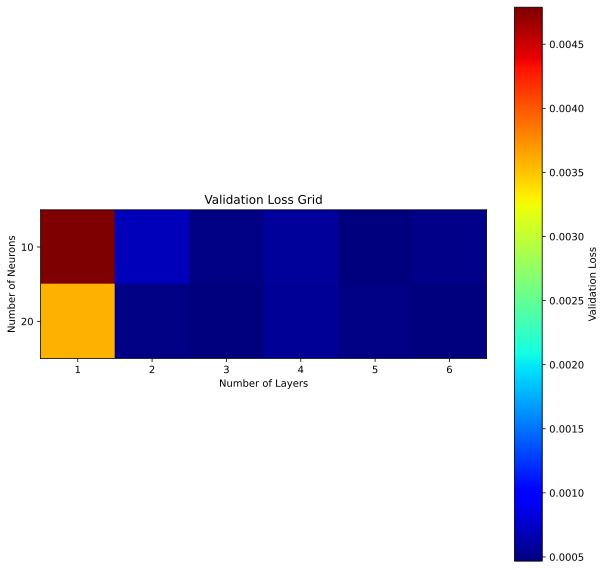

In [19]:
# Define the row and column labels
rows = layer_sizes
cols = layer_numbers

plt.figure(figsize=(10, 10))
plt.imshow(val_loss_grid, cmap='jet', interpolation='nearest')

# Add a colorbar
plt.colorbar(label='Validation Loss')

# Add the row and column labels
plt.xticks(range(len(cols)), cols)
plt.yticks(range(len(rows)), rows)

plt.xlabel('Number of Layers')
plt.ylabel('Number of Neurons')

plt.title('Validation Loss Grid')
plt.show()



This code will create a heatmap where the color intensity represents the validation loss. The colorbar on the side provides a reference for the loss values. The row and column labels represent the number of neurons and layers, respectively.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 4.2:</b>

It is finally time to plot the performance of our best model in detail! In the next block we set up and train again the best model found by the grid search procedure. 

Your task is to use this trained model to produce parity plots for training and validation, like the ones from Parts 2 and 3. Use the code you already developed!

But now we can also finally take a look at the **test dataset** that we never touched (we did not use it for training nor for selecting the architecture). The error on the test set should serve as the final check for your model, on data that the model has really never seen, directly or indirectly.

Add these plots in your report.
</div>

Epoch 1/500 - Train Loss: 0.1664 - Val Loss: 0.1845
Epoch 2/500 - Train Loss: 0.1592 - Val Loss: 0.1527
Epoch 3/500 - Train Loss: 0.0719 - Val Loss: 0.0745
Epoch 4/500 - Train Loss: 0.0708 - Val Loss: 0.0775
Epoch 5/500 - Train Loss: 0.0538 - Val Loss: 0.0570
Epoch 6/500 - Train Loss: 0.0384 - Val Loss: 0.0404
Epoch 7/500 - Train Loss: 0.0244 - Val Loss: 0.0249
Epoch 8/500 - Train Loss: 0.0164 - Val Loss: 0.0152
Epoch 9/500 - Train Loss: 0.0152 - Val Loss: 0.0139
Epoch 10/500 - Train Loss: 0.0147 - Val Loss: 0.0132
Epoch 11/500 - Train Loss: 0.0143 - Val Loss: 0.0131
Epoch 12/500 - Train Loss: 0.0140 - Val Loss: 0.0128
Epoch 13/500 - Train Loss: 0.0138 - Val Loss: 0.0126
Epoch 14/500 - Train Loss: 0.0134 - Val Loss: 0.0120
Epoch 15/500 - Train Loss: 0.0131 - Val Loss: 0.0117
Epoch 16/500 - Train Loss: 0.0129 - Val Loss: 0.0116
Epoch 17/500 - Train Loss: 0.0127 - Val Loss: 0.0112
Epoch 18/500 - Train Loss: 0.0121 - Val Loss: 0.0107
Epoch 19/500 - Train Loss: 0.0121 - Val Loss: 0.0106
Ep

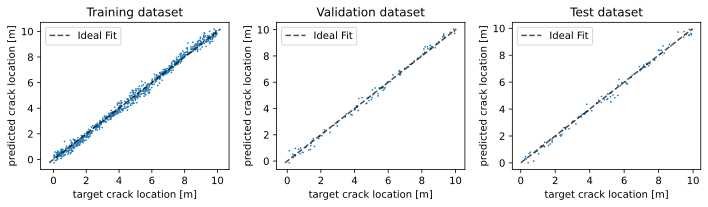

In [20]:
# Normalize the test inputs
normalized_X_test = scaler_x.transform(X_test)

# Set up NN
# Fix random_state=0 to make sure this is consistent with the model in the loop above
layers = (layer_sizes[min_size],) * layer_numbers[min_number]
model = MLPRegressor(hidden_layer_sizes=layers, activation='tanh', random_state=0)

# train NN
_,  val_loss_list = train_model(model, 
                                normalized_X_train, 
                                normalized_t_train,
                                normalized_X_val, 
                                normalized_t_val, 
                                n_epochs=500, 
                                batch_size=64,
                                learning_rate=0.001
                                )

# YOUR_CODE_HERE

#Solution
y_train = scaler_t.inverse_transform(model.predict(normalized_X_train).reshape(-1,1))
y_val = scaler_t.inverse_transform(model.predict(normalized_X_val).reshape(-1,1))
y_test = scaler_t.inverse_transform(model.predict(normalized_X_test).reshape(-1,1))

fig,axes = plt.subplots(1,3,figsize=(10,3))

axes[0].scatter(t_train,y_train,s=0.5)

axes[0].set_title('Training dataset')
axes[0].set_xlabel('target crack location [m]')
axes[0].set_ylabel('predicted crack location [m]')

min_val = min(np.min(t_train), np.min(y_train))
max_val = max(np.max(t_train), np.max(y_train))
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[0].legend()

axes[1].scatter(t_val,y_val,s=0.5)

axes[1].set_title('Validation dataset')
axes[1].set_xlabel('target crack location [m]')
axes[1].set_ylabel('predicted crack location [m]')

min_val = min(np.min(t_val), np.min(y_val))
max_val = max(np.max(t_val), np.max(y_val))
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[1].legend()

axes[2].scatter(t_test,y_test,s=0.5)

axes[2].set_title('Test dataset')
axes[2].set_xlabel('target crack location [m]')
axes[2].set_ylabel('predicted crack location [m]')

min_val = min(np.min(t_test), np.min(y_test))
max_val = max(np.max(t_test), np.max(y_test))
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit', alpha=0.7)
axes[2].legend()

plt.tight_layout()

<div style="background-color:#FFC5CB; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Questions:</b>

4.1) How does hyperparameter tuning in machine learning relate to the concept of model complexity?

4.2) Given a comprehensive list of layer sizes and numbers, and given a relatively small training dataset, we expect the top left corner of the heatmap to have high validation errors. Why is that?

4.3) Following up on the previous question, we also expect the bottom right corner of the heatmap to have high validation errors. Why is that?

4.4) How does the performance of your final model for this part compare with the one you tweaked manually?

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.